In [13]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Gather information

먼저 사용자 요구사항을 수집할 그래프의 부분을 정의해보겠습니다.

이는 특정 시스템 메시지가 포함된 LLM 호출이 될 것입니다. 프롬프트를 생성할 준비가 되었을 때 호출할 수 있는 도구에 접근할 수 있습니다.

1. 사용자로부터 `요구사항` 을 수집하고

2. 특별한 시스템 메시지를 포함한 `LLM` 을 호출하며

3. 프롬프트 생성이 필요할 때 사용할 수 있는 `도구`를 제공합니다

In [2]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [16]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(temperature=0, model="gpt-4o")
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## Generate Prompt

이제 프롬프트를 생성할 상태를 설정하겠습니다. 이를 위해서는 별도의 시스템 메시지가 필요하며, 도구 호출 이전의 모든 메시지를 필터링하는 함수도 필요합니다 (이전 상태에서 프롬프트를 생성할 시점이라고 결정했을 때의 시점입니다).

1. 프롬프트 생성을 위한 상태(state) 설정

2. 별도의 시스템 메시지 필요성

3. 이전 메시지 필터링 함수의 필요성을 설명하고 있습니다.


In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

## Define the state logic

이것은 챗봇이 어떤 상태에 있는지를 결정하는 로직입니다.

마지막 메시지가 도구 호출인 경우, "프롬프트 생성기"(prompt)가 응답해야 하는 상태입니다. 

그렇지 않고 마지막 메시지가 HumanMessage가 아닌 경우, 다음은 사용자가 응답해야 하므로 END 상태입니다. 

마지막 메시지가 HumanMessage인 경우, 이전에 도구 호출이 있었다면 prompt 상태이고, 그렇지 않다면 "정보 수집"(info) 상태입니다.

In [5]:
from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

## Create the graph

이제 그래프를 생성할 수 있습니다. 

SqliteSaver를 사용하여 대화 기록을 지속적으로 저장합니다.

In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

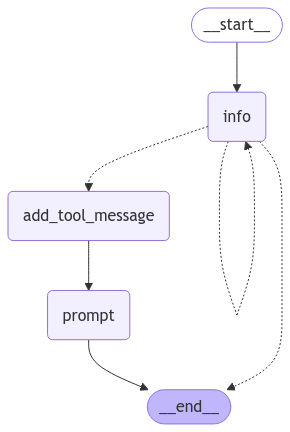

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): 나는 유튜브 스크립트 내용을 가지고 핵심내용 요약 및 인사이트 도출하는 프롬프트를 만들고 싶어
================================== Ai Message ==================================

좋습니다! 유튜브 스크립트 내용을 요약하고 인사이트를 도출하는 프롬프트를 만들기 위해 다음 정보를 확인하고 싶습니다:

1. **프롬프트의 목표**: 유튜브 스크립트의 핵심 내용을 요약하고 인사이트를 도출하는 것인가요?

2. **프롬프트 템플릿에 전달될 변수**: 유튜브 스크립트의 텍스트가 될까요? 다른 변수도 필요한가요?

3. **출력에 대한 제약 조건**: 출력이 특정 형식을 따르지 않아야 한다거나, 특정 내용을 포함하지 않아야 하는 등의 제약 조건이 있나요?

4. **출력이 반드시 따라야 할 요구 사항**: 요약의 길이, 인사이트의 수, 특정 형식 등 반드시 포함되어야 할 요구 사항이 있나요?

이 정보를 바탕으로 프롬프트 템플릿을 설계할 수 있습니다. 추가 정보가 필요하면 말씀해 주세요!
User (q/Q to quit): 1. 맞아 2. 유튜브 스크립트의 텍스트 3. 제약 조건 없음 4. 핵심내용이 요약된 overview와 주요 키워드 그리고 핵심 인사이트내용이 불릿포인트로 작성되었으면 좋겠어
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (call_YBtOaUx2IT207qUjyJtWHXi0)
 Call ID: call_YBtOaUx2IT207qUjyJtWHXi0
  Args:
    objective: 유튜브 스크립트의 핵심 내용을 요약하고 인사이트를 도출
    variables: ['유튜브 스크립트의 텍스트']
    constraints: []
    requirements: ['핵심내용이 요약된 overvie